# Detect Pneumonia with Deep Learning

## **Imports and data access**

In [ ]:
import numpy as np 
import cv2
import os
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Concatenate, \
                                    AveragePooling2D, Input, Flatten, MaxPool2D, Dropout, Add
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import  categorical_crossentropy
import pandas as pd
from google.colab import drive


In [ ]:
#Connect to the Google Driver
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = '/content/drive/MyDrive/Pneumonia_data/train_images/' #directory of the train images
test_path = '/content/drive/MyDrive/Pneumonia_data/test_images/'  #directory of the test images

In [ ]:
df_labels = pd.read_csv('/content/drive/MyDrive/Pneumonia_data/labels_train.csv') #Create a data frame includes the Labels of the train dataset
train_image = df_labels['file_name'].values #Getting the title of each label
labels = df_labels['class_id'].values # Getting the label of each class_id 
print(len(train_image),len(labels)) # Just to be sure about the shape
test_images_names = [img for img in os.listdir(test_path)] # Getting the images names from test dataset

4672 4672


## **Data pre-processing**

In [ ]:
#Creating a fuction that converts an image number into the file path where the image is located, opens the image, and returns the image as a numpy array.

img_h = 256
image_w = 256
def get_image(row_ids, root='/content/drive/MyDrive/Pneumonia_data/train_images/'):
    X = []
    for image_id in row_ids:
      file_path = os.path.join(root, image_id)
      img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
      resized_X = cv2.resize(img, (img_h,image_w))
      
      X.append(resized_X)
    return np.array(X)

In [ ]:
#Creating our X_train with the fuction get_image as numpy array
X_train = get_image(train_image) 

In [ ]:
# Just to be sure about the shape of our numpy array
print(X_train.shape)

(4672, 256, 256)


In [ ]:
#Creating our X_test with the fuction get_image as numpy array
X_test = get_image(test_images_names, root = test_path )

In [ ]:
# Just to be sure about the shape of our numpy array
print(X_test.shape)

(1168, 256, 256)


In [ ]:
#Converting our labels to numpy array
labels = np.array(labels)

In [ ]:
# Just to be sure about the shape of our numpy array
print(labels.shape)

(4672,)


In [ ]:
# Splitting our data to X_train, X_val, Y_train and Y_val. Setting the size of test set to 10% of the dataset and random_state equal to 1
X_train, X_val, Y_train, Y_val = train_test_split(X_train, labels, test_size=0.10, random_state=1)

In [ ]:
#Just to be sure about the image size to 256, while we reshape the arrays and setting the input shape.
#Also, we normalize the train, validation and test data.
img_size = 256
# reshape data for deep learning 
X_train = X_train.reshape(-1, img_size, img_size, 1)
Y_train = np.array(Y_train)

X_val = X_val.reshape(-1, img_size, img_size, 1)
Y_val = np.array(Y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)

# Input image dimensions
input_shape = X_train.shape[1:]

# Normalize Train and Validation data
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

X_train_mean = np.mean(X_train, axis=0)

X_train -= X_train_mean
X_val -= X_train_mean

# Normalize Test data
X_test = X_test.astype('float32') / 255.0
X_test -= X_train_mean

In [ ]:
# Just to be sure about the shape of our numpy array
print(X_train.shape)
print(X_val.shape)

(4204, 256, 256, 1)
(468, 256, 256, 1)


In [ ]:
# With the use of keras library we convert our data to categorical
from keras.utils import to_categorical

Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)

## **Model Building**

In [ ]:
#Setting imageDataGenerator that applies any random transformations on each training image as it is passed to the model
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

#Setting a fuction that change the lr value depending on epoch iterations. 
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 100:
        lr *= 0.5e-3
    elif epoch > 80:
        lr *= 1e-3
    elif epoch > 60:
        lr *= 1e-2
    elif epoch > 40:
        lr *= 1e-1
    return lr

In [ ]:
#Setting the number of classes as many as we want to predict, 3 
num_classes = 3
#Creating a fuction of the model we will use to make our predictions using as parameter the input_shape
def cnn_2(input_shape):
    x_in = Input(shape=input_shape) #Setting the starting x_in with the shape like our input shape which we created before, to fit to the model. 
    
    x = Conv2D(filters=32, kernel_size=(3,3),kernel_initializer="he_normal",kernel_regularizer=l2(1e-4), padding ="same")(x_in) # Using 2D convolution layer , with 32 filters, each kernel size 3,3. Also we use the set the kernel_initializer to he_normal and the regulizer to l2(1e-4), while setting padding to same.
    x = BatchNormalization()(x) # We use Batch Normalization for stabilizing the learning process
    x = Activation('relu')(x) # Setting the Activasion to relu
    x = MaxPool2D(pool_size= (2))(x) #Setting MaxPool2D, pool_size = 2 to reduce its dimensionality
    x = Dropout(rate=0.5)(x) #Setting Dropout rate to 0.5 to reduce the capacity
  
    x = Conv2D(filters=32, kernel_size=(3,3),kernel_initializer="he_normal",kernel_regularizer=l2(1e-4), padding ="same")(x) # Creating a new 2D convolution layer , with 32 filters, each kernel size 3,3. Also we use the set the kernel_initializer to he_normal and the regulizer to l2(1e-4), while setting padding to same.
    x = BatchNormalization()(x)# We use Batch Normalization for stabilizing the learning process
    x = Activation('relu')(x)# Setting the Activasion to relu
    x = MaxPool2D(pool_size= (2))(x)#Setting MaxPool2D, pool_size = 2 to reduce its dimensionality
    x = Dropout(rate=0.3)(x)#Setting Dropout rate to 0.3 to reduce the capacity

    x = Conv2D(filters=64, kernel_size=(3,3),kernel_initializer="he_normal",kernel_regularizer=l2(1e-4), padding="same")(x) # Creating a new 2D convolution layer , with 64 filters, each kernel size 3,3. Also we use the set the kernel_initializer to he_normal and the regulizer to l2(1e-4), while setting padding to same.
    x = BatchNormalization()(x)# We use Batch Normalization for stabilizing the learning process
    x = Activation('relu')(x)# Setting the Activasion to relu
    x = MaxPool2D(pool_size= (2))(x)#Setting MaxPool2D, pool_size = 2 to reduce its dimensionality
    x = Dropout(rate=0.2)(x) #Setting Dropout rate to 0.2 to reduce the capacity

    x = Conv2D(filters=64, kernel_size=(3,3),kernel_initializer="he_normal",kernel_regularizer=l2(1e-4), padding="same")(x) # Creating a new 2D convolution layer , with 64 filters, each kernel size 3,3. Also we use the set the kernel_initializer to he_normal and the regulizer to l2(1e-4), while setting padding to same.
    x = BatchNormalization()(x)# We use Batch Normalization for stabilizing the learning process
    x = Activation('relu')(x)# Setting the Activasion to relu
    x = AveragePooling2D(pool_size= (2))(x)#Setting MaxPool2D, pool_size = 2 to reduce its dimensionality
    x = Dropout(rate=0.1)(x) #Setting Dropout rate to 0.1 to reduce the capacity

    x = Conv2D(filters=64, kernel_size=(3,3),kernel_initializer="he_normal",kernel_regularizer=l2(1e-4), padding="same")(x) # Creating a new 2D convolution layer , with 64 filters, each kernel size 3,3. Also we use the set the kernel_initializer to he_normal and the regulizer to l2(1e-4), while setting padding to same.
    x = BatchNormalization()(x)# We use Batch Normalization for stabilizing the learning process
    x = Activation('relu')(x)# Setting the Activasion to relu
    x = AveragePooling2D(pool_size= (2))(x)#Setting MaxPool2D, pool_size = 2 to reduce its dimensionality
    x = Dropout(rate=0.05)(x) #Setting Dropout rate to 0.05 to reduce the capacity

    x = Conv2D(filters=64, kernel_size=(3,3),kernel_initializer="he_normal",kernel_regularizer=l2(1e-4), padding="same")(x) # Creating a new 2D convolution layer , with 64 filters, each kernel size 3,3. Also we use the set the kernel_initializer to he_normal and the regulizer to l2(1e-4), while setting padding to same.
    x = BatchNormalization()(x)# We use Batch Normalization for stabilizing the learning process
    x = Activation('relu')(x)# Setting the Activasion to relu
    x = AveragePooling2D(pool_size= (2))(x)#Setting MaxPool2D, pool_size = 2 to reduce its dimensionality
    x = Dropout(rate=0.05)(x) #Setting Dropout rate to 0.05 to reduce the capacity

    x = Flatten()(x) #We flatten the output of the convolutional layers to create a single long feature vector
    x = Dense(512, activation='relu')(x)# Setting Dense 512 the Activasion to relu
    x = Dropout(rate=0.2)(x)#Setting Dropout rate to 0.2 to reduce the capacity
    x = Dense(512, activation='relu')(x)# Setting Dense 512 the Activasion to relu
    x = BatchNormalization()(x)# We use Batch Normalization for stabilizing the learning process
    x = Dropout(rate=0.2)(x)#Setting Dropout rate to 0.2 to reduce the capacity
    x = Dense(512, activation='relu')(x)# Setting Dense 512 the Activasion to relu
 
 # Complete our model with dense with num_classes = 3 and softmax activation, using optimizer Adam, and the lr_schedule we created before. Metric = Accuracy   
    out = Dense(num_classes, activation='softmax')(x) 
    model = Model(inputs=x_in, outputs=out)
    return model

model = cnn_2(input_shape)

model.compile(loss='categorical_crossentropy', #Using categorical_crossentropy
              optimizer=Adam(lr=lr_schedule(0)), # Optimizer Adam, with lr_schedule
              metrics=['accuracy']) #Using accurace as metric
model.summary()   

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248  

In [ ]:
# We use 120 epoch and batch size equal to 32.
max_epochs = 120
batch_size = 32
scheduler = LearningRateScheduler(lr_schedule)

#Checkpoint cal_accuracy to see our best accuracy score in val.
checkpoint = ModelCheckpoint('model.h5', 
                             verbose=1, 
                             monitor='val_accuracy', 
                             save_best_only=True)
#Applying the model in our dataset.
history = model.fit(datagen.flow(x=X_train, y=Y_train),
                    validation_data=datagen.flow(X_val,Y_val),
                    batch_size=batch_size,
                    epochs=max_epochs,
                    callbacks = [scheduler, checkpoint],
                    verbose=1)

Epoch 1/120
132/132 [==============================] - 55s 160ms/step - loss: 1.0903 - accuracy: 0.5664 - val_loss: 13.6634 - val_accuracy: 0.4722

Epoch 00001: val_accuracy improved from -inf to 0.47222, saving model to model.h5
Epoch 2/120
132/132 [==============================] - 20s 151ms/step - loss: 0.8305 - accuracy: 0.6758 - val_loss: 9.8370 - val_accuracy: 0.2415

Epoch 00002: val_accuracy did not improve from 0.47222
Epoch 3/120
132/132 [==============================] - 20s 151ms/step - loss: 0.7258 - accuracy: 0.7165 - val_loss: 8.5581 - val_accuracy: 0.4722

Epoch 00003: val_accuracy did not improve from 0.47222
Epoch 4/120
132/132 [==============================] - 20s 151ms/step - loss: 0.6879 - accuracy: 0.7366 - val_loss: 3.6357 - val_accuracy: 0.4786

Epoch 00004: val_accuracy improved from 0.47222 to 0.47863, saving model to model.h5
Epoch 5/120
132/132 [==============================] - 20s 150ms/step - loss: 0.6418 - accuracy: 0.7555 - val_loss: 1.5698 - val_accur

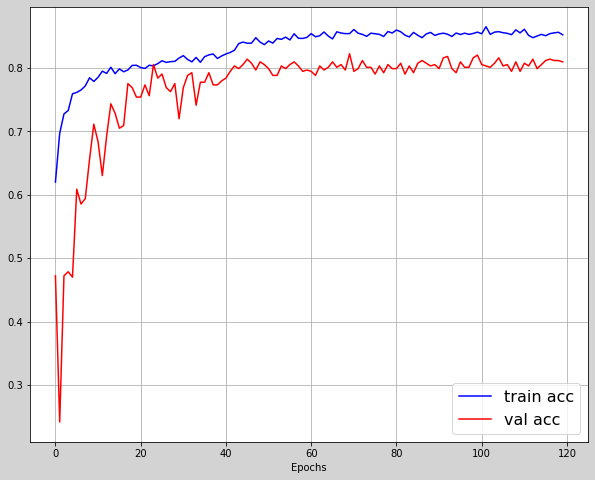

In [ ]:
#Creating plot with Train set accuracy, and Validation set accuracy checking about overfitting
fig, ax = plt.subplots(figsize=(10,8))
fig.set_facecolor('lightgray')
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.legend(['train acc', 'val acc'], fontsize=16)
plt.xlabel('Epochs')
plt.grid(b=True)

## **Making Predictions**

In [ ]:
#Apply our model to our test dataset
Y_test_prob = model.predict(X_test)
print(Y_test_prob)

[[9.9579382e-01 9.8306010e-04 3.2231319e-03]
 [3.4007359e-02 7.2296846e-01 2.4302414e-01]
 [7.7447523e-03 1.1290122e-01 8.7935400e-01]
 ...
 [1.9368990e-05 2.8099859e-01 7.1898204e-01]
 [3.4785924e-05 8.2143039e-01 1.7853491e-01]
 [6.2132413e-03 6.0920238e-01 3.8458446e-01]]


In [ ]:
#Modify to 0,1,2
Y_test = Y_test_prob.argmax(axis=-1)
print(Y_test)

[0 1 2 ... 2 1 1]


In [ ]:
#Create dataframe with file names and labels for test dataset
test_names = [i for i in os.listdir(test_path)]

df_test = pd.DataFrame (test_names, columns=['file_name'])

df_test.head()
df_test['class_id'] = Y_test
df_labels.head(10)

,file_name,class_id
0,img_4358977458434011046.jpg,1
1,img_5224016757187192130.jpg,2
2,img_3065202206106254707.jpg,2
3,img_6304894865561547174.jpg,1
4,img_3371338542810939877.jpg,2
5,img_946797649386887230.jpg,0
6,img_3282952127033205295.jpg,0
7,img_3090153597350897926.jpg,1
8,img_4875755942606271156.jpg,1
9,img_4787814488043878610.jpg,1


In [ ]:
#Saving as csv to our Google Drive.
df_test.to_csv('/content/drive/MyDrive/Georgios Papageorgiou subm 256b.csv', sep = ',', index = False)